# HHG 2 Sample Class

## AD Variant

In [1]:
from hyppo.ksample.base import KSampleTest
from hyppo.ksample._utils import _CheckInputs
from sklearn.metrics import pairwise_distances
from scipy.stats import anderson_ksamp
import numpy as np
import random

class HHGKSample(KSampleTest):
    def __init__(self, compute_distance="euclidean", **kwargs):
        self.compute_distance = compute_distance
        KSampleTest.__init__(self, compute_distance=compute_distance, **kwargs)
        
    def statistic(self, y1, y2):
        disty1, disty2 = self._centerpoint_dist(y1, y2, self.compute_distance, 1)
        stat, crit, pvalue = anderson_ksamp([disty1, disty2])
        self.stat=stat
        return stat
        
    def test(self, y1, y2):
        disty1, disty2 = self._centerpoint_dist(y1, y2, self.compute_distance, 1)
        #Simple AD Implementation
        stat, crit, pvalue = anderson_ksamp([disty1,disty2], midrank=True)
        return stat, crit, pvalue
        
    def _centerpoint_dist(self, y1, y2, metric, workers=1, **kwargs):
        y = np.concatenate((y1,y2), axis=0)
        #Random Center Point
        z = random.randint(0,len(y)-1)
        zy = y[z]
        #CM as center point
        zy = np.mean(y, axis=0)
        zy = np.array(zy).reshape(1,-1)
        yin1 = np.concatenate((zy, y1))
        yin2 = np.concatenate((zy, y2))
        if callable(metric):
            disty1 = metric(yin1, **kwargs)
            disty1 = metric(yin2, **kwargs)
        else:
            disty1 = pairwise_distances(yin1, metric=metric, n_jobs=workers, **kwargs)
            disty2 = pairwise_distances(yin2, metric=metric, n_jobs=workers, **kwargs)
        disty1 = np.delete(disty1[0],0)
        disty2 = np.delete(disty2[0],0)
        disty1 = disty1.reshape(-1)
        disty2 = disty2.reshape(-1)
        return disty1, disty2


## minP Variant

In [2]:
from scipy.stats import rankdata
import math
from math import log
import numpy as np
from random import randint

class HHGKSample_minP(KSampleTest):
    def __init__(self, compute_distance="euclidean", **kwargs):
        self.compute_distance = compute_distance
        KSampleTest.__init__(self, compute_distance=compute_distance, **kwargs)
        
    def statistic(self, y1, y2):
        disty1, disty2 = self._centerpoint_dist(y1, y2, self.compute_distance, 1)
        stat, crit, pvalue = anderson_ksamp([disty1, disty2])
        self.stat=stat
        return stat
        
    def test(self, y1, y2):
        x1 = np.ones(len(y1))
        x2 = np.full(len(y2),fill_value=2)
        x = np.concatenate((x1,x2), axis=0)
        disty1, disty2 = self._centerpoint_dist(y1, y2, self.compute_distance, 1)
        #minP Implementation
        partitionscore = self._minP(disty1, disty2)
        return partitionscore
        
    def _minP(self, disty1, disty2):
        Ng = np.empty(2, dtype=int)
        Ng[0] = len(disty1)
        Ng[1] = len(disty2)
        N = np.sum(Ng)
        x1 = np.zeros(Ng[0])
        x2 = np.ones(Ng[1])
        x = np.concatenate((x1,x2), axis=0)
        yrank = rankdata([disty1, disty2])
        data = []
        Sm = np.zeros(N)
        for i in range(0, len(x)):
            data = data + [[x[i], yrank[i]]]
        data = sorted(data, key = lambda x: x[1])
        for n, p in enumerate(self._partitions(data), 1):
            TL = 0
            for c in p:
                tc = 0
                for g in range(0,2):
                    Ocg = sum([element[0] == g for element in c])
                    Ecg = len(c)*Ng[g]/N
                    if Ocg == 0:
                        tc += 0
                    else:
                        tc += Ocg*log(Ocg/Ecg)
                TL += tc
            Sm[len(p)-1] += TL
        pvalues, nullscores = self._redistribute(Ng, 100, Sm)
        minP = min(pvalues)
        
        return Sm, minP, pvalues, nullscores 
        """
        TODO: 
        - Find ways to speed up partitioning
        - minP function
        """
            
    def _partitions(self, collection):
        if len(collection) ==1:
            yield[collection]
            return
        first = collection[0]
        for smaller in self._partitions(collection[1:]):
            yield [[ first ] + smaller[0]] + smaller[1:]
            yield [[first]] + smaller
        
    def _redistribute(self, sizes, B, observedscore):
        #Perform partition scoring on B random reassignments
        nullscores = []
        N = np.sum(sizes)
        for i in range(B):
            reassign = []
            N1fill = 0
            N2fill = 0
            for rank in range(1,N+1):
                coin = randint(0,1)
                if coin == 0:
                    if N1fill != sizes[0]:
                        reassign = reassign + [[coin, rank]]
                        N1fill += 1
                    else:
                        coin = 1
                        reassign = reassign + [[coin, rank]]
                        N2fill += 1
                elif coin == 1:
                    if N2fill != sizes[1]:
                        reassign = reassign + [[coin, rank]]
                        N2fill += 1
                    else:
                        coin = 0
                        reassign = reassign + [[coin, rank]]
                        N1fill += 1
            reassign = sorted(reassign, key = lambda x: x[1])
            partitionscore = np.zeros(N)
            #find test statistic for redistribution
            for n, p in enumerate(self._partitions(reassign), 1):
                TL = 0
                for c in p:
                    tc = 0
                    for g in range(0,2):
                        Ocg = sum([element[0] == g for element in c])
                        Ecg = len(c)*sizes[g]/N
                        if Ocg == 0:
                            tc += 0
                        else:
                            tc += Ocg*log(Ocg/Ecg)
                    TL += tc
                partitionscore[len(p)-1] += TL
            nullscores.append(partitionscore)
        nullscores = np.array(nullscores)
        pvalues = []
        for m, score in enumerate(observedscore):
            pvalues.append((1+sum(nullscores[:,m] >= score))/(B+1))
        return pvalues, nullscores
        
    def _centerpoint_dist(self, y1, y2, metric, workers=1, **kwargs):
        y = np.concatenate((y1,y2), axis=0)
        zy = np.mean(y, axis=0)
        zy = np.array(zy).reshape(1,-1)
        yin1 = np.concatenate((zy, y1))
        yin2 = np.concatenate((zy, y2))
        if callable(metric):
            disty1 = metric(yin1, **kwargs)
            disty1 = metric(yin2, **kwargs)
        else:
            disty1 = pairwise_distances(yin1, metric=metric, n_jobs=workers, **kwargs)
            disty2 = pairwise_distances(yin2, metric=metric, n_jobs=workers, **kwargs)
        disty1 = np.delete(disty1[0],0)
        disty2 = np.delete(disty2[0],0)
        disty1 = disty1.reshape(-1)
        disty2 = disty2.reshape(-1)
        return disty1, disty2

In [3]:
from numpy.random import multivariate_normal
import time

minP = HHGKSample_minP()

start = time.perf_counter()
y1 = multivariate_normal([0,0], [[1, 0],[0, 1]], 7)
y2 = multivariate_normal([0,0.05], [[0.9, 0],[0, 0.9]], 7)

score, pvalues, nullscores  = minP.test(y1,y2)
print(time.perf_counter()-start)
print(score)
print(nullscores)

KeyboardInterrupt: 

In [3]:
#Hotelling T2 Test as Sanity Check on Test Cases
import numpy as np
from sklearn import datasets
from scipy.stats import f
def TwoSampleT2Test(X, Y):
    nx, p = X.shape
    ny, _ = Y.shape
    delta = np.mean(X, axis=0) - np.mean(Y, axis=0)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False)
    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    t_squared = (nx*ny)/(nx+ny) * np.matmul(np.matmul(delta.transpose(), np.linalg.inv(S_pooled)), delta)
    statistic = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(statistic)
    #print(f"Test statistic: {statistic}\nDegrees of freedom: {p} and {nx+ny-p-1}\np-value: {p_value}")
    return statistic, p_value

# Comparison to Paper Experiment

## Original Paper Figure and Table
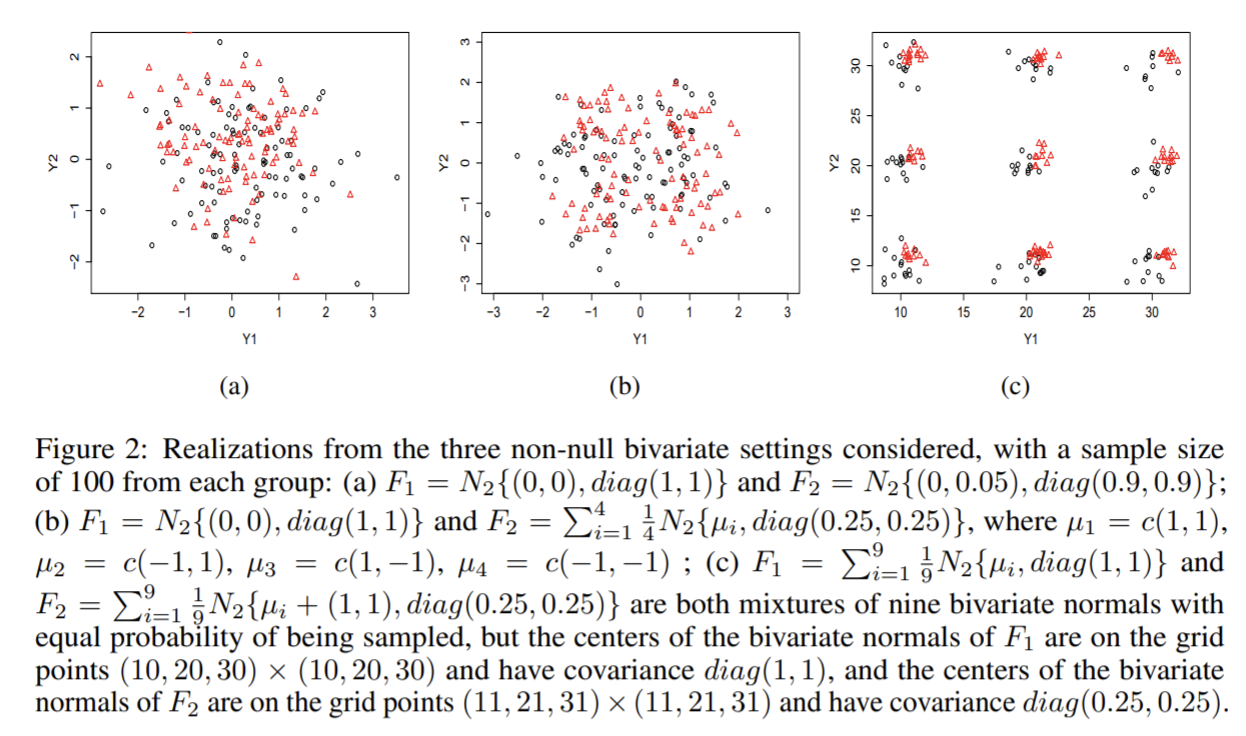

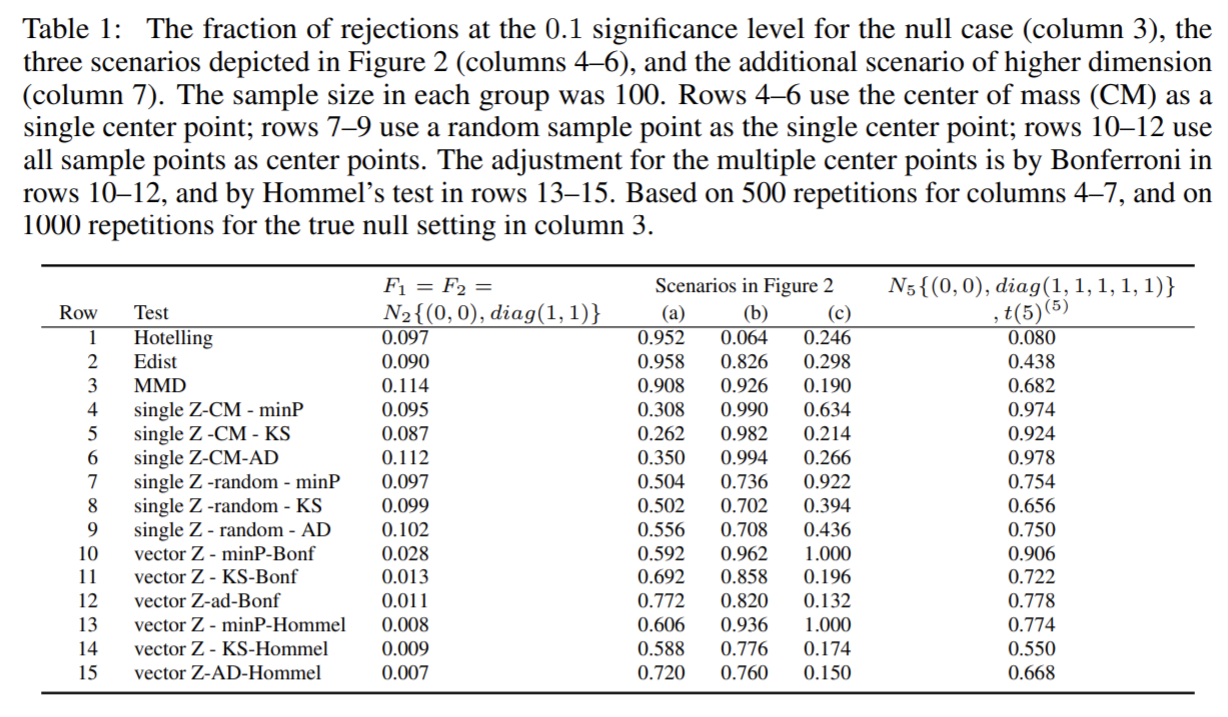

### Scenario A

REPLICATING SCENARIO A OF ORIGINAL PAPER
Point Method: Center of Mass
Fraction of rejections at significance level 0.10 = 0.178
Fraction of rejections at significance level 0.10 for Hotelling T2= 0.098


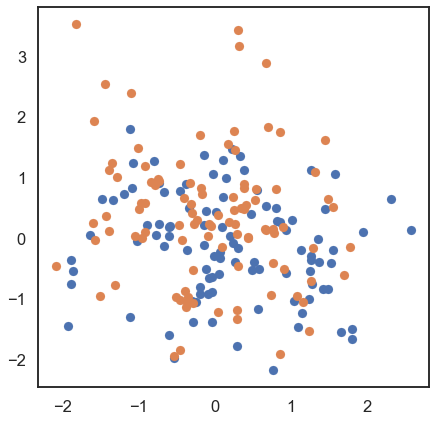

In [10]:
#Repeating Scenario A of Figure 2 of original paper
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# make plots look pretty
sns.set(color_codes=True, style="white", context="talk", font_scale=1)

y1 = multivariate_normal([0,0], [[1, 0],[0, 1]], 100)
y2 = multivariate_normal([0,0.05], [[0.9, 0],[0, 0.9]], 100)

plt.figure(figsize=(7, 7))
plt.scatter(y1[:,0],y1[:,1], linewidths=0.2)
plt.scatter(y2[:,0],y2[:,1], linewidths=0.2)

Ksamp = HHGKSample()
CMrejections = 0
T2rejections =0
loops = 500

#AD - Center of Mass
for i in range(loops):
    y1 = multivariate_normal([0,0], [[1, 0],[0, 1]], 100)
    y2 = multivariate_normal([0,0.05], [[0.9, 0],[0, 0.9]], 100)

    stat, crit, pvalue = Ksamp.test(y1, y2)
    if pvalue < 0.10:
        CMrejections += 1
    
    stat, pvalue = TwoSampleT2Test(y1, y2)
    if pvalue <= 0.10:
        T2rejections += 1
        
print('REPLICATING SCENARIO A OF ORIGINAL PAPER')
print('Point Method: Center of Mass')
print('Fraction of rejections at significance level 0.10 =', CMrejections/loops) 
#corresponds to result of row 6, column 4 of Table 1
        
print('Fraction of rejections at significance level 0.10 for Hotelling T2=', T2rejections/loops)

REPLICATING SCENARIO B OF ORIGINAL PAPER
Point Method: Center of Mass
Fraction of rejections at significance level 0.1 = 0.994
Fraction of rejections at significance level 0.1 for Hotelling T2= 0.074


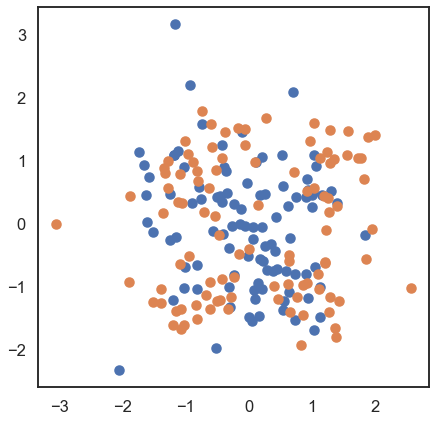

In [11]:
#Repeating Scenario B of Figure 2 of original paper with Center of Mass
from numpy.random import multivariate_normal

Ksamp = HHGKSample()

#scatter plot of non-null distribution
x = multivariate_normal([0,0], [[1, 0],[0, 1]], 100)
y1 = multivariate_normal([1,1], [[0.25, 0],[0, 0.25]], 25)
y2 = multivariate_normal([1,-1], [[0.25, 0],[0, 0.25]], 25)
y3 = multivariate_normal([-1,1], [[0.25, 0],[0, 0.25]], 25)
y4 = multivariate_normal([-1,-1], [[0.25, 0],[0, 0.25]], 25)
y = np.concatenate([y1,y2,y3,y4], axis=0)

n = 100 
index = np.random.choice(y.shape[0], n, replace=False)
y = y[index]

plt.figure(figsize=(7, 7))
plt.scatter(x[:,0],x[:,1])
plt.scatter(y[:,0],y[:,1])

rejections = 0
T2rejections = 0

for i in range(500):
    x = multivariate_normal([0,0], [[1, 0],[0, 1]], 100)
    y1 = multivariate_normal([1,1], [[0.25, 0],[0, 0.25]], 100)
    y2 = multivariate_normal([1,-1], [[0.25, 0],[0, 0.25]], 100)
    y3 = multivariate_normal([-1,1], [[0.25, 0],[0, 0.25]], 100)
    y4 = multivariate_normal([-1,-1], [[0.25, 0],[0, 0.25]], 100)
    y = np.concatenate([y1,y2,y3,y4], axis=0)
    
    n = 100 
    index = np.random.choice(y.shape[0], n, replace=False)
    y = y[index]
    
    stat, crit, pvalue = Ksamp.test(x, y)
    if pvalue < 0.1:
        rejections += 1
    
    stat, pvalue = TwoSampleT2Test(x, y)
    if pvalue< 0.10:
        T2rejections += 1

print('REPLICATING SCENARIO B OF ORIGINAL PAPER')
print('Point Method: Center of Mass')
print('Fraction of rejections at significance level 0.1 =', rejections/500) #should correspond to result of row 6, column 5 of Table 1
print('Fraction of rejections at significance level 0.1 for Hotelling T2=', T2rejections/500)

REPLICATING SCENARIO C OF ORIGINAL PAPER
Point Method: Center of Mass
Fraction of rejections at significance level 0.1 = 0.24
Fraction of rejections at significance level 0.1 for Hotelling T2= 0.214


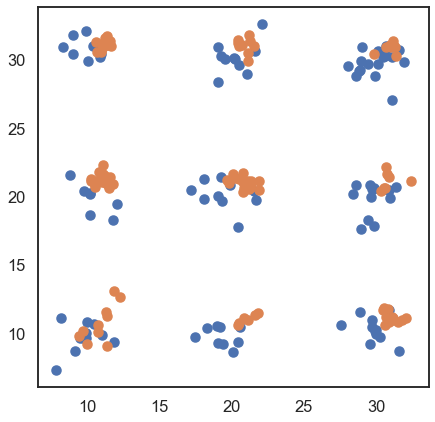

In [12]:
#Replicating Scenario C of Figure 2 of original paper with Center of Mass
from numpy.random import multivariate_normal

Ksamp = HHGKSample()

centers = [[10,10],
          [10,20],
          [10,30],
          [20,10],
          [20,20],
          [20,30],
          [30,10],
          [30,20],
          [30,30]]

x = multivariate_normal(centers[0], [[1, 0],[0, 1]], 100)
y = multivariate_normal(np.add(centers[0],[1,1]), [[1, 0],[0, 1]], 100)

for i in range(1,9):
    xi = multivariate_normal(centers[i], [[1, 0],[0, 1]], 100)
    yi = multivariate_normal(np.add(centers[i],[1,1]), [[0.25, 0],[0, 0.25]], 100)
    x = np.concatenate([x,xi], axis=0)
    y = np.concatenate([y,yi], axis=0)
    
n = 100 
index = np.random.choice(x.shape[0], n, replace=False)
xtest = x[index]
index = np.random.choice(y.shape[0], n, replace=False)
ytest = y[index]

plt.figure(figsize=(7, 7))
plt.scatter(xtest[:,0],xtest[:,1])
plt.scatter(ytest[:,0],ytest[:,1])

rejections = 0
T2rejections = 0

for i in range(500):
    x = multivariate_normal(centers[0], [[1, 0],[0, 1]], 100)
    y = multivariate_normal(np.add(centers[0],[1,1]), [[1, 0],[0, 1]], 100)

    for i in range(1,9):
        xi = multivariate_normal(centers[i], [[1, 0],[0, 1]], 100)
        yi = multivariate_normal(np.add(centers[i],[1,1]), [[0.25, 0],[0, 0.25]], 100)
        x = np.concatenate([x,xi], axis=0)
        y = np.concatenate([y,yi], axis=0)
    
    n = 100 
    index = np.random.choice(x.shape[0], n, replace=False)
    xtest = x[index]
    index = np.random.choice(y.shape[0], n, replace=False)
    ytest = y[index]
    
    stat, crit, pvalue = Ksamp.test(xtest, ytest)
    if pvalue < 0.1:
        rejections += 1
        
    stat, pvalue = TwoSampleT2Test(xtest, ytest)
    if pvalue< 0.10:
        T2rejections += 1

print('REPLICATING SCENARIO C OF ORIGINAL PAPER')
print('Point Method: Center of Mass')
print('Fraction of rejections at significance level 0.1 =', rejections/500) #should correspond to result of row 6, column 6 of Table 1
print('Fraction of rejections at significance level 0.1 for Hotelling T2=', T2rejections/500)

In [31]:
#Replicating Multidimension Test of Table 1 of original paper
#X has standard normal distribution of dimension 5
#Y is the multivariate t distribution, where each 5 independent coordinates has the univariate t distribution
#with 5 degrees of freedom

from numpy.random import standard_t

Ksamp = HHGKSample()

rejections = 0
for i in range(500):
    x = multivariate_normal([0, 0, 0, 0, 0], np.diag([1,1,1,1,1]), 100)
    y1 = standard_t(5, 100)
    y2 = standard_t(5, 100)
    y3 = standard_t(5, 100)
    y4 = standard_t(5, 100)
    y5 = standard_t(5, 100)
    y = np.concatenate([y1[:, None],y2[:, None],y3[:, None],y4[:, None],y5[:, None]], axis = 1)
    
    stat, crit, pvalue = Ksamp.test(x, y)
    
    if pvalue < 0.1:
        rejections += 1

print('REPLICATING MULTIDIMENSION TEST')
print('Point Method: Center of Mass')
print('Fraction of rejections at significance level 0.1 =',rejections/500) #should correspond to result of row 6, column 7 of Table 1

REPLICATING MULTIDIMENSION TEST
Point Method: Center of Mass
Fraction of rejections at significance level 0.1 = 0.784


In [32]:
from hyppo.tools import w_shaped

#Results when testing true null case
rejections = 0
loops = 1000
for i in range(loops):
    x = multivariate_normal([0,0], [[1, 0],[0, 1]], 100)
    y = multivariate_normal([0,0], [[1, 0],[0, 1]], 100)

    stat, crit, pvalue = Ksamp.test(x, y)
    
    if pvalue < 0.10:
        rejections += 1

print('TESTING TRUE NULL CASE')
print('Point Method: Center of Mass')
print('Fraction of rejections at significance level 0.1 =',rejections/loops) #corresponds to result of row 5, column 3 of Table 1

TESTING TRUE NULL CASE
Point Method: Center of Mass
Fraction of rejections at significance level 0.1 = 0.093
